In [23]:
import os
from importlib.resources import files

import numpy as np
import torch
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3D

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry
from learn_embedding.utils import *

## Load Dataset

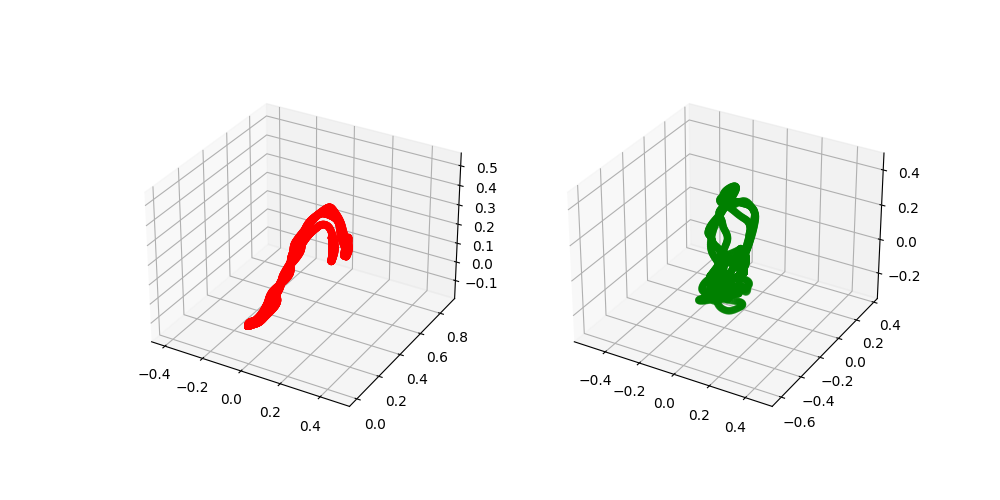

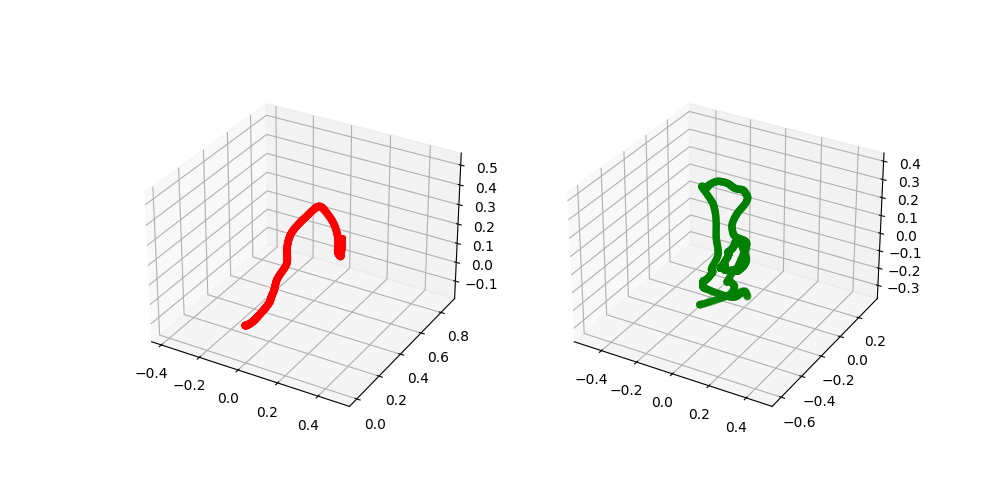

In [2]:
dataset = "robotic_demo_5"
data_path = files('learn_embedding').joinpath(os.path.join('data/roboticdemos', '{}.pkl'.format(dataset)))
data = RoboticDemos(data_path)
train_x, train_y, test_x, test_y = data.load().process().dataset(target="velocity", split=0.8, visualize=True)
dim = train_y.shape[1]

## Torch Configuration

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
train_x = torch.from_numpy(train_x).float().to(device).requires_grad_(True)
train_y = torch.from_numpy(train_y).float().to(device)
test_x = torch.from_numpy(test_x).float().to(device).requires_grad_(True)
test_y = torch.from_numpy(test_y).float().to(device)

## Create Model

In [4]:
# torch.manual_seed(1337)
# approximator = KernelExpansion(train_x)
# approximator = KernelMachine(dim, 1000, 1, length=0.01)
approximator = FeedForward(dim, [32,32,32], 1)

embedding = Embedding(approximator)

stiffness = SPD(dim)

attractor = train_x[-1, :]

model = FirstGeometry(embedding, attractor, stiffness).to(device)
TorchHelper.load(model,'../outputs/' + dataset + '_1')

## Train

In [5]:
trainer = Trainer(model, train_x, train_y)
trainer.optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
trainer.loss = torch.nn.MSELoss()
# trainer.loss = torch.nn.SmoothL1Loss()
trainer.options(normalize=False, shuffle=True, print_loss=True,epochs=1000)
# trainer.train()
# TorchHelper.save(model, '../outputs/' + dataset + '_1')

## Test

In [6]:
resolution = 100
std = train_x.detach().std(axis=0)
min_ax = train_x.detach().min(axis=0)[0] - std/2
max_ax = train_x.detach().max(axis=0)[0] + std/2

### Vector Field & Streamlines

Text(0.5, 0.5, '$x^3$')

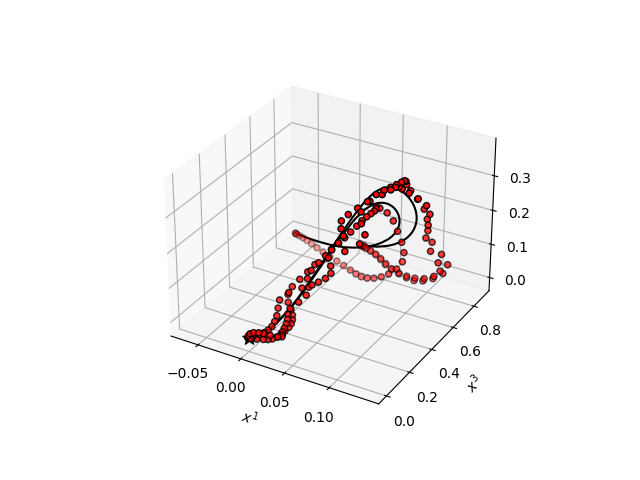

In [7]:
obstacle_radius = 0.1 # 0.05 , 0.1
obstacle = torch.tensor([[-0.4,-0.4]])
# obstacle = Obstacles.square(center=torch.tensor([-30,20]), a=20, b=20, res=10)
# obstacle = Obstacles.semi_circle(radius=0.2, center=torch.tensor([-0.4,   -0.4]), rot=torch.tensor(torch.pi/4), res=50)
decay = 5e-1
lengthscale = np.sqrt(-0.5*obstacle_radius**2/np.log(decay))
phi = KernelDeformation(obstacle.to(device), weights = 10.0*torch.ones(obstacle.shape[0]).to(device), kernel=SquaredExp(l=lengthscale)).to(device)
# embedding.local_deformation = phi

# x0 = train_x[0, :dim].unsqueeze(0)
x0 = torch.stack((train_x[0, :dim],train_x[643, :dim]))
streamlines = Integrator.first_order(dynamics=model,x0=x0,T=10, dt=0.01).cpu().detach().numpy()

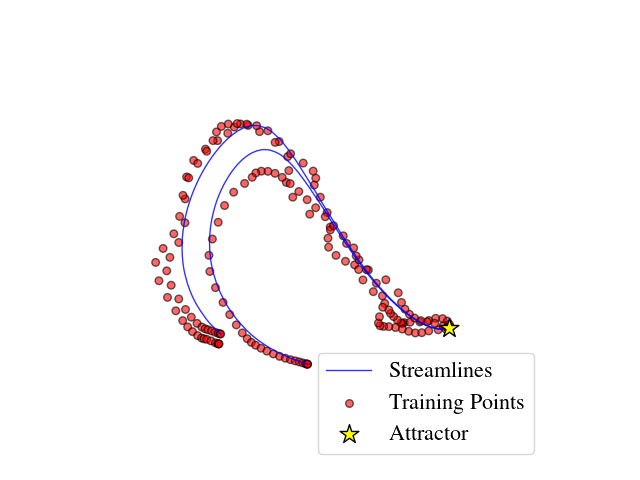

In [55]:
# Enable LaTeX rendering
mpl.rcParams['text.usetex'] = True

# Set Times as the font family
mpl.rcParams['font.family'] = 'Times'

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d", computed_zorder=False)

# Scatter plot for last train_x point
scatter_last = ax.scatter(train_x.cpu().detach()[-1, 0], train_x.cpu().detach()[-1, 1], train_x.cpu().detach()[-1, 2],
           s=200, edgecolors='k', c='yellow', marker='*', alpha=1, label='Attractor', zorder=10)

# Plotting streamlines
lines = []
for i in range(streamlines.shape[1]):
    line = ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], streamlines[:, i, 2], linewidth=1, color='blue', alpha=0.8)
    lines.append(line[0])

# Scatter plot for train_x points
scatter_train = ax.scatter(train_x.cpu().detach()[::10, 0], train_x.cpu().detach()[::10, 1], train_x.cpu().detach()[::10, 2],
           s=30, edgecolors='k', c='red', alpha=0.6, label='Training Points')

# Create dummy Line3D object for legend entry of streamlines
dummy_line = Line3D([0], [0], [0], color='blue', linewidth=1, alpha=0.8, label='Streamlines')
ax.add_artist(dummy_line)

# Set limits for better visibility
ax.set_xlim([streamlines[:, :, 0].min(), streamlines[:, :, 0].max()])
ax.set_ylim([streamlines[:, :, 1].min(), streamlines[:, :, 1].max()])
ax.set_zlim([streamlines[:, :, 2].min(), streamlines[:, :, 2].max()])

# Set viewing angle and elevation angle
ax.view_init(elev=5, azim=140)  # Adjust the elevation (up/down) and azimuth (left/right) angles

# Create custom legend for streamlines
ax.legend(handles=[dummy_line, scatter_train, scatter_last], loc='lower right', fontsize=16)

# # Remove axis
ax.axis('off')
# ax.grid(False)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])


# Adjust layout
fig.tight_layout()

# Save the plot
fig.savefig('3d_learned_trajecory.png', format='png', dpi=300, bbox_inches="tight")